In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
covid_data_dir_0 = r'data/raw/DOH COVID Data Drop_ 20220521 - 04 Case Information_batch_0.csv'
covid_data_dir_1 = r'data/raw/DOH COVID Data Drop_ 20220521 - 04 Case Information_batch_1.csv'
covid_data_dir_2 = r'data/raw/DOH COVID Data Drop_ 20220521 - 04 Case Information_batch_2.csv'
covid_data_dir_3 = r'data/raw/DOH COVID Data Drop_ 20220521 - 04 Case Information_batch_3.csv'

bnd_data_dir = r'data/processed/merge.shp'

In [3]:
df_covid_0 = pd.read_csv(covid_data_dir_0)
df_covid_1 = pd.read_csv(covid_data_dir_1)
df_covid_2 = pd.read_csv(covid_data_dir_2)
df_covid_3 = pd.read_csv(covid_data_dir_3)

df_bnd = gpd.read_file(bnd_data_dir)

/tmp/ipykernel_54658/3910334582.py:1: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_covid_0 = pd.read_csv(covid_data_dir_0)
/tmp/ipykernel_54658/3910334582.py:4: DtypeWarning: Columns (7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_covid_3 = pd.read_csv(covid_data_dir_3)


In [4]:
df_covid = pd.concat([df_covid_0,df_covid_1,df_covid_2,df_covid_3],axis=0)

<AxesSubplot:xlabel='DateRepConf'>

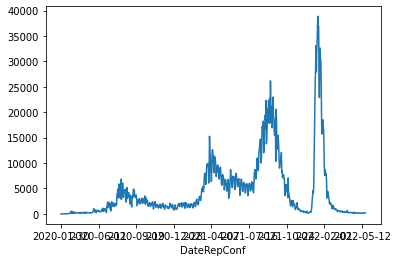

In [5]:
df_covid.groupby('DateRepConf').CaseCode.count().plot()

In [6]:
# subset to delta surge
df_covid['DateRepConf'] = pd.to_datetime(df_covid.DateRepConf)

delta_subset = df_covid.loc[(df_covid.DateRepConf>=pd.to_datetime('2021-07-01')) & 
                            (df_covid.DateRepConf<=pd.to_datetime('2021-10-31'))]

<AxesSubplot:xlabel='DateRepConf'>

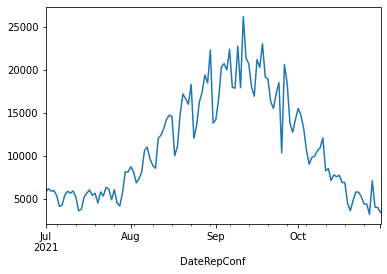

In [7]:
delta_subset.groupby('DateRepConf').CaseCode.count().plot()

In [8]:
delta_subset.head(1)

,CaseCode,Age,AgeGroup,Sex,DateSpecimen,DateResultRelease,DateRepConf,DateDied,DateRecover,RemovalType,...,ProvRes,CityMunRes,CityMuniPSGC,BarangayRes,BarangayPSGC,HealthStatus,Quarantined,DateOnset,Pregnanttab,ValidationStatus
409983,C10870550,14.0,10 to 14,MALE,2021-06-29,2021-06-29,2021-07-01,NaN,NaN,RECOVERED,...,ANTIQUE,ANINI-Y,PH060601000,SALVACION,PH060601019,RECOVERED,YES,2021-06-29,NaN,"Removal Type is ""Recovered"", but no Recovered ..."


In [9]:
base = delta_subset.groupby(['BarangayPSGC','DateRepConf']).CaseCode.count().reset_index().sort_values('CaseCode')

In [10]:
aug15 = base.loc[base.DateRepConf == pd.to_datetime('2021-08-15')]

In [11]:
aug15.head(1)

,BarangayPSGC,DateRepConf,CaseCode
297925,PH071238014,2021-08-15,1


In [12]:
sample = df_bnd.merge(aug15, left_on='Bgy_Code', right_on='BarangayPSGC', how='inner')

In [13]:
sample['DateRepConf'] = sample.DateRepConf.astype('str')

In [14]:
sample.to_file(r'data/processed/delta_aug15_bgy.shp')

/tmp/ipykernel_54658/553248187.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  sample.to_file(r'data/processed/delta_aug15_bgy.shp')


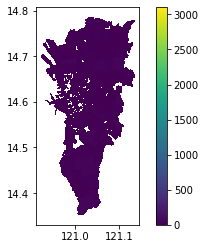

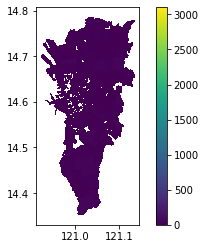

In [32]:
sample.loc[sample.Reg_Code=='PH130000000'].plot(column='CaseCode',
                                                legend=True, 
                                                vmin=0, 
                                                vmax=3100, 
                                                k=5, 
                                                antialiased=False,
                                                linewidth=0).get_figure()

In [16]:
mm_bnd = df_bnd.loc[df_bnd.Reg_Code=='PH130000000']

In [17]:
# compute cumulative cases per barangay per date

In [18]:
base['cumsum'] = base[['BarangayPSGC','CaseCode']].groupby('BarangayPSGC').cumsum()

In [19]:
base.describe()

,CaseCode,cumsum
count,528096.000000,528096.000000
mean,2.530263,47.287137
std,3.833914,124.880459
min,1.000000,1.000000
25%,1.000000,5.000000
50%,1.000000,13.000000
75%,2.000000,36.000000
max,216.000000,3079.000000


/home/gab/Desktop/covid-bgy-time-slider/covid-bgy-geoprocess/venv/lib/python3.10/site-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


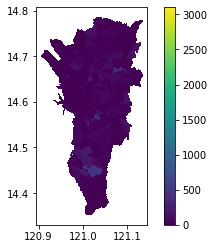

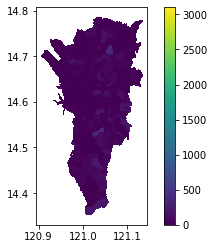

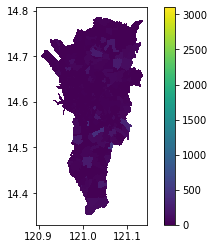

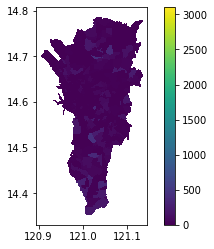

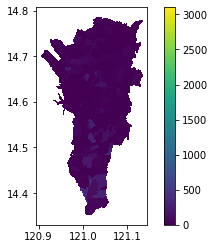

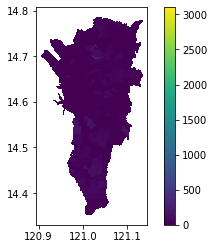

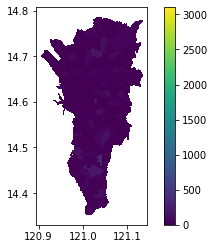

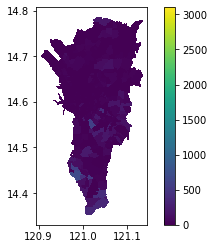

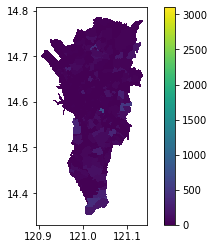

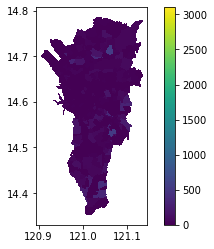

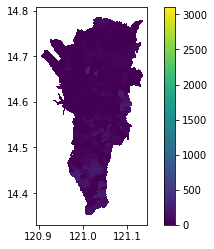

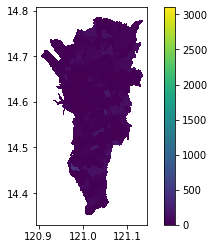

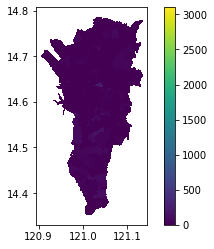

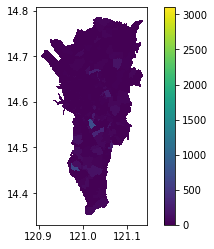

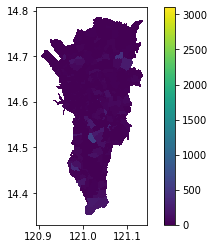

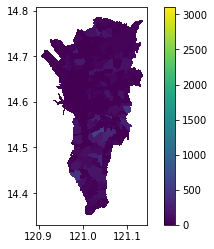

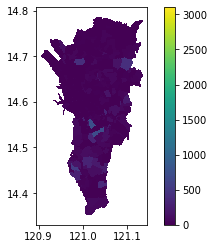

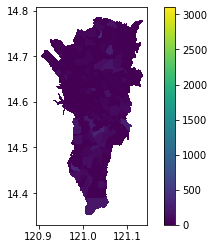

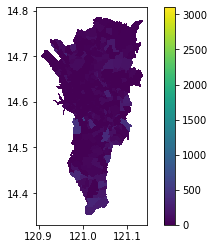

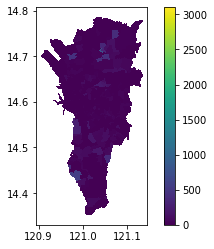

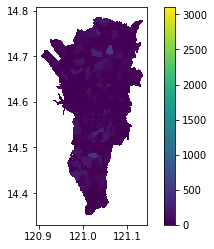

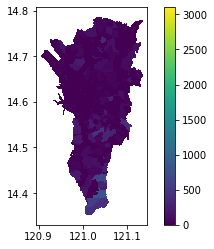

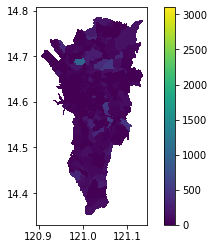

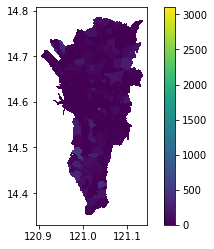

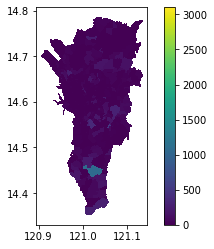

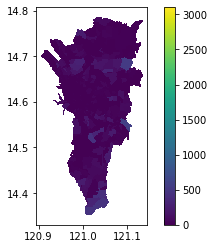

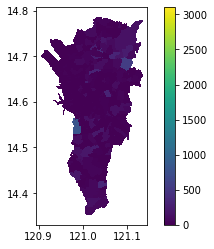

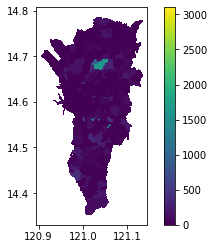

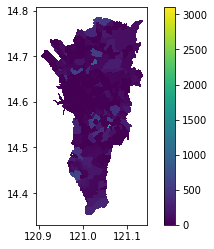

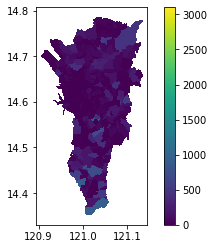

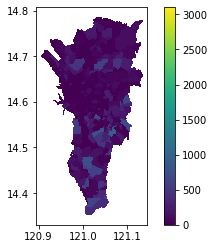

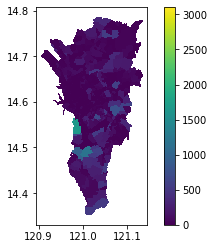

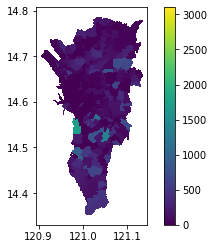

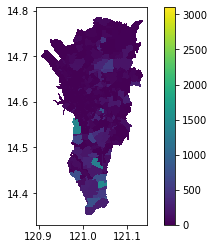

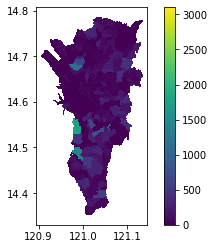

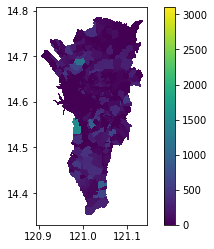

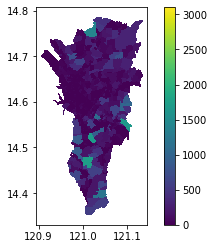

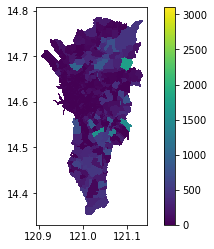

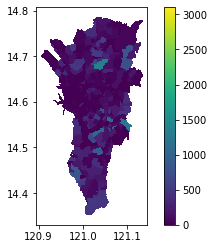

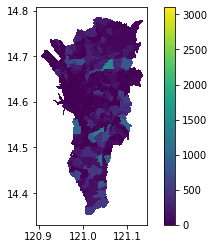

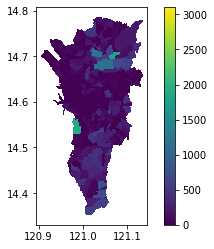

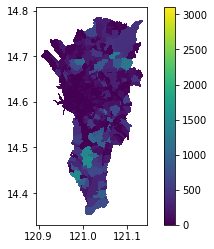

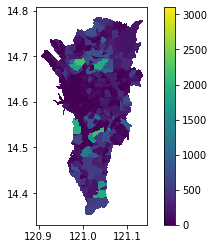

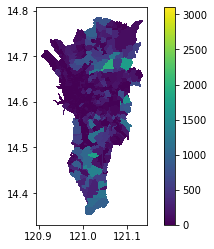

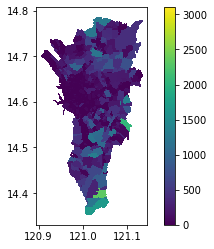

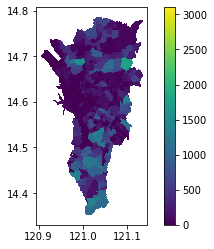

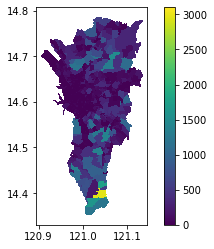

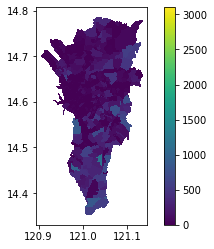

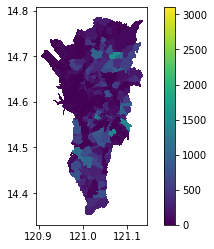

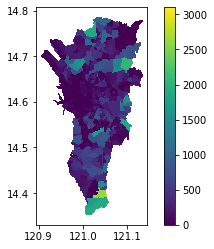

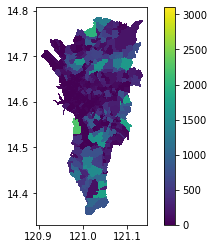

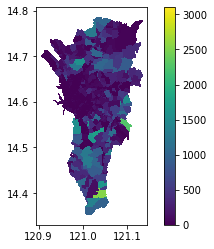

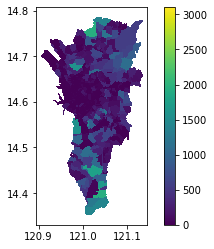

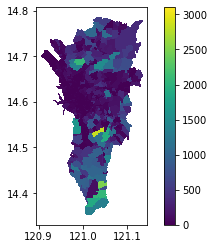

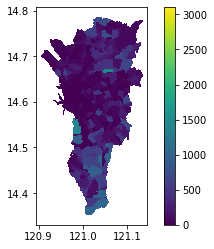

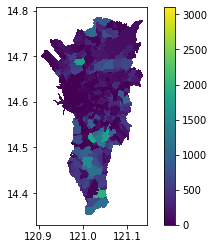

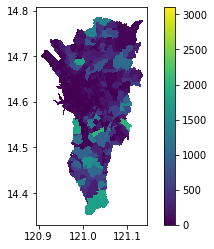

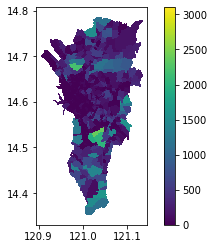

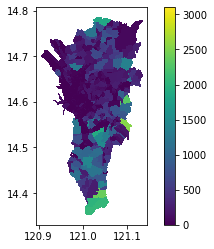

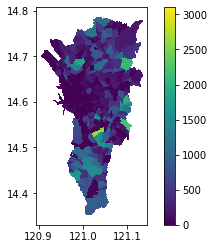

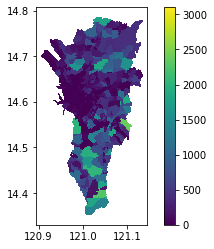

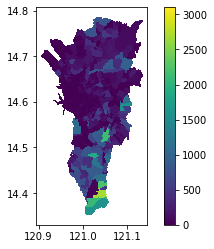

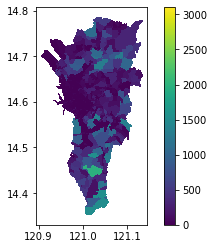

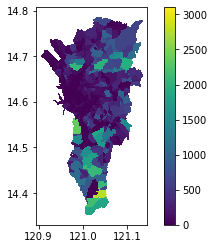

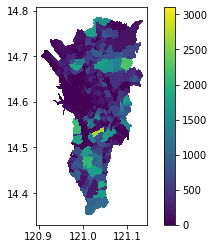

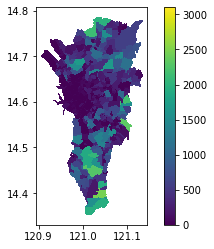

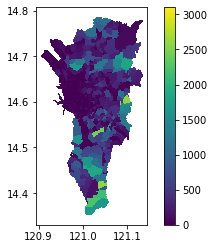

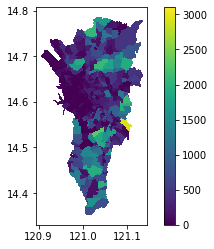

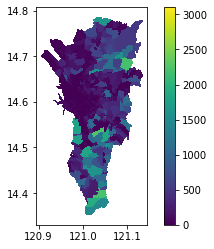

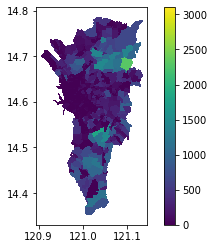

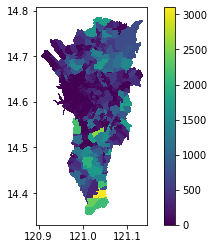

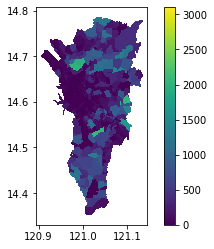

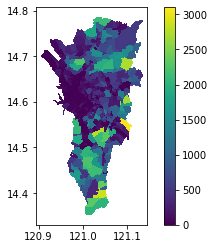

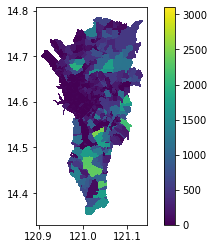

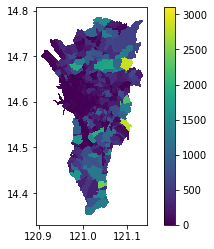

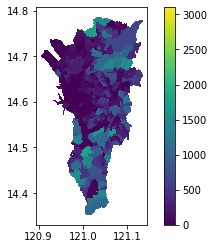

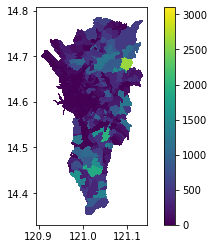

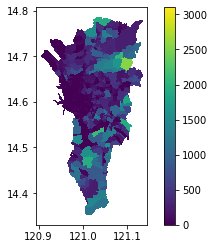

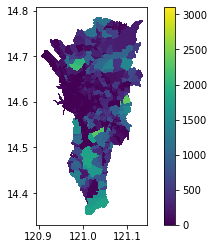

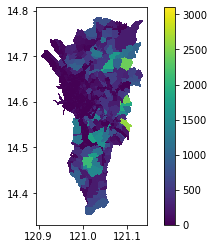

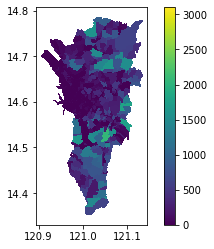

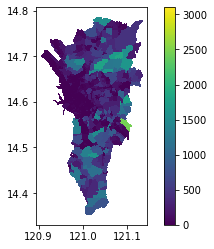

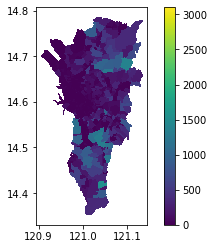

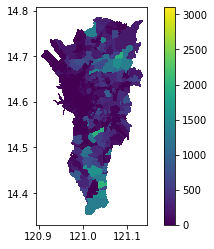

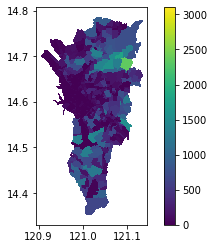

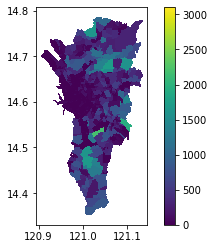

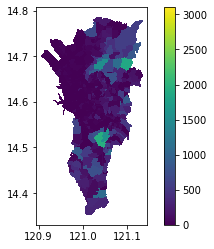

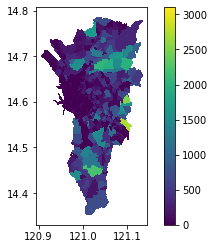

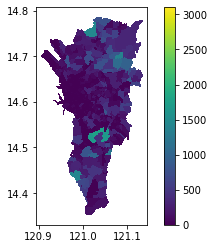

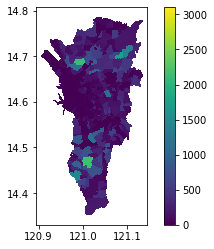

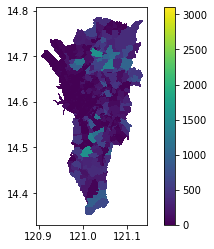

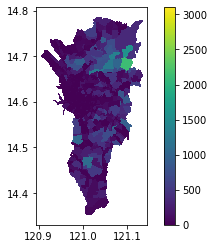

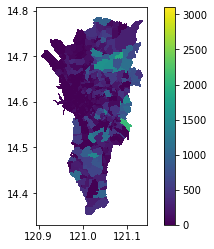

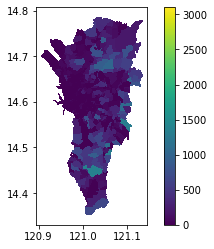

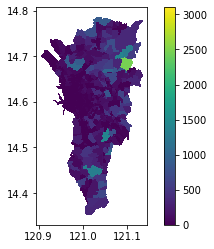

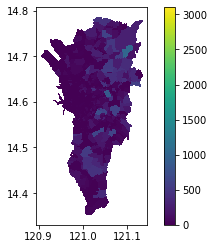

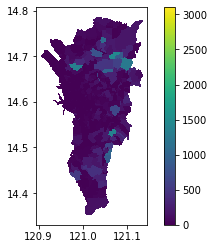

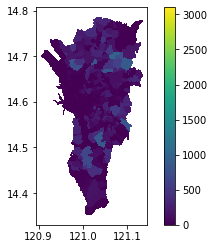

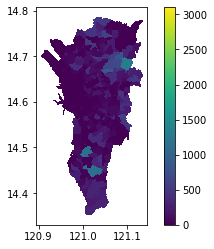

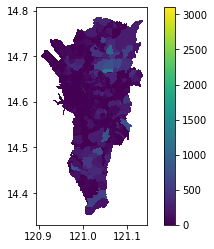

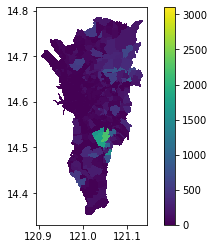

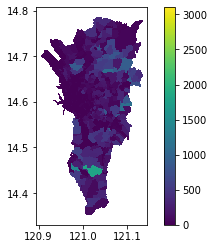

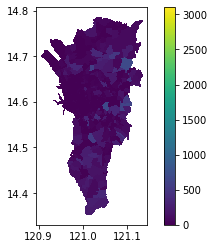

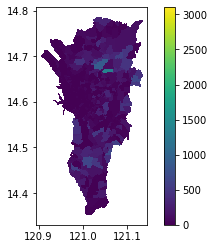

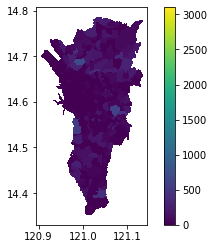

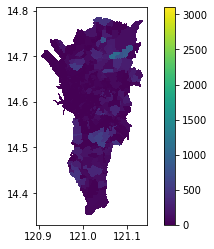

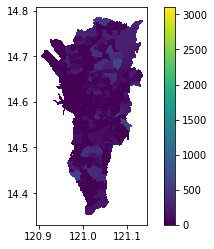

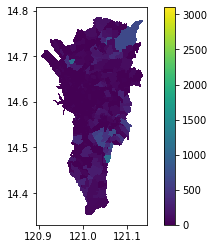

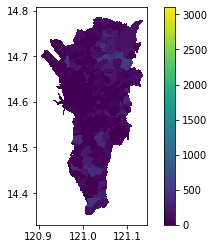

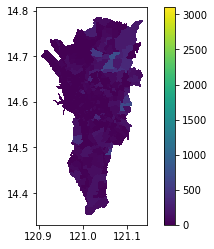

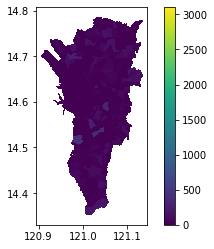

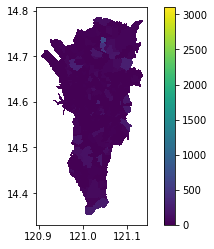

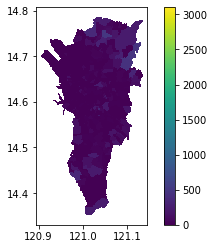

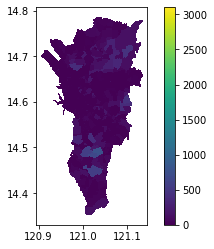

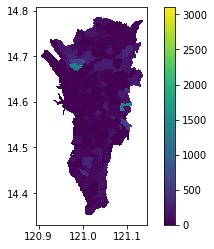

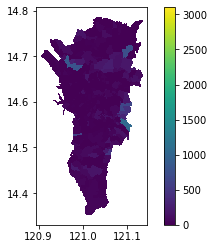

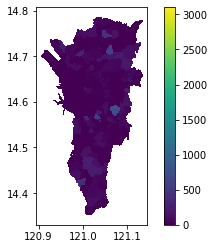

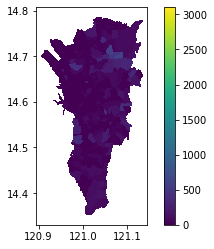

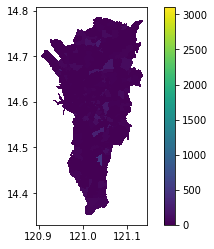

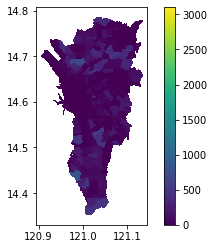

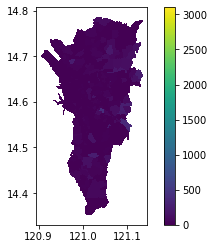

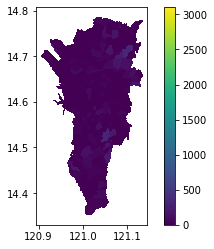

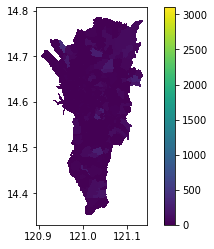

In [33]:
for i,date in enumerate(base['DateRepConf'].sort_values().unique()):
    seg = base.loc[base.DateRepConf==date]
    a = mm_bnd.merge(seg, left_on='Bgy_Code', right_on='BarangayPSGC', how='left')
    a['cumsum'].fillna(0,inplace=True)
    a.plot(column='cumsum', 
           legend=True, 
           vmin=0, 
           vmax=3100, 
           # TODO: Fix intervals using mapclassify and classification_kwd param
           k=5,
           antialiased=False).get_figure().savefig(f"plots/{date}.jpg")

### NOTES
- Use cumulative sum instead of case counts per day, because counts are daily snapshots per location. What we want to see over time and space are the growth of cases 